In [1]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab import drive
import os
import tensorflow_hub as hub

In [ ]:
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

tf.debugging.set_log_device_placement(True)

try:
  # Specify an invalid GPU device
  with tf.device('/device:GPU:0'):
    a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
    b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
    c = tf.matmul(a, b)
except RuntimeError as e:
  print(e)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0


In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
path = '/content/drive/My Drive/Images'

In [5]:
import pathlib
data = pathlib.Path('/content/drive/My Drive/Images/') 
count = len(list(data.glob('*.jpg')))
count

0

In [6]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(path)
print(TRAINING_DATA_DIR);
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="validation",
shuffle=True,
target_size=IMAGE_SHAPE
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="training",
shuffle=True,
target_size=IMAGE_SHAPE)

/content/drive/My Drive/Images
Found 853 images belonging to 12 classes.
Found 3435 images belonging to 12 classes.


In [7]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 12)
['American_Kestrel' 'American_Robin' 'Blue_Jay' 'Carolina_Chickadee'
 'Carolina_Wren' 'Common_Grackle' 'Eastern_Phoebe' 'European_Starling'
 'Great_Blue_Heron' 'Great_Egret' 'Northern_Flicker'
 'Northern_Mockingbird']


In [8]:
pip install tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
model = tf.keras.Sequential([hub.KerasLayer('https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4',
output_shape=[1280],
trainable=False),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()
model.compile(
optimizer=tf.keras.optimizers.Adam(),
loss='categorical_crossentropy',
metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 12)                15372     
                                                                 
Total params: 2,273,356
Trainable params: 15,372
Non-trainable params: 2,257,984
_________________________________________________________________


In [10]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()
model.compile(
optimizer=tf.keras.optimizers.Adam(),
loss='categorical_crossentropy',
metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)       

In [13]:
fit_model = model.fit(train_generator, validation_data = valid_generator,epochs=10)

Epoch 1/10
108/108 [==============================] - 46s 427ms/step - loss: 2.2249 - acc: 0.1508 - val_loss: 2.2264 - val_acc: 0.1676
Epoch 2/10
108/108 [==============================] - 45s 417ms/step - loss: 2.2232 - acc: 0.1610 - val_loss: 2.2180 - val_acc: 0.1676
Epoch 3/10
108/108 [==============================] - 43s 402ms/step - loss: 2.2188 - acc: 0.1595 - val_loss: 2.2077 - val_acc: 0.1641
Epoch 4/10
108/108 [==============================] - 43s 396ms/step - loss: 2.2175 - acc: 0.1665 - val_loss: 2.2259 - val_acc: 0.1676
Epoch 5/10
108/108 [==============================] - 43s 400ms/step - loss: 2.2255 - acc: 0.1563 - val_loss: 2.2306 - val_acc: 0.1676
Epoch 6/10
108/108 [==============================] - 44s 408ms/step - loss: 2.2222 - acc: 0.1523 - val_loss: 2.2078 - val_acc: 0.1676
Epoch 7/10
108/108 [==============================] - 46s 429ms/step - loss: 2.2178 - acc: 0.1622 - val_loss: 2.2083 - val_acc: 0.1641
Epoch 8/10
108/108 [==============================] - 4

In [27]:
# Evaluate the model using the validation data
model_loss, model_accuracy = model.evaluate(valid_generator)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

27/27 [==============================] - 9s 324ms/step - loss: 2.2057 - acc: 0.1676
Loss: 2.2057247161865234, Accuracy: 0.16764360666275024


In [16]:
saved_model_path = "/content/drive/My Drive/bird_model.h5" # or you can simply use 'my_mode.h5'
model.save(saved_model_path) #save your model 

# to reload your model 
model = keras.models.load_model(saved_model_path)

In [17]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [23]:
tf_model_predictions = model.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe.head()

1/1 [==============================] - 0s 25ms/step
Prediction results for the first elements


,American_Kestrel,American_Robin,Blue_Jay,Carolina_Chickadee,Carolina_Wren,Common_Grackle,Eastern_Phoebe,European_Starling,Great_Blue_Heron,Great_Egret,Northern_Flicker,Northern_Mockingbird
0,0.026448,0.015169,0.022262,0.013409,0.175045,0.181768,0.082493,0.097979,0.117654,0.135716,0.016775,0.115282
1,0.026448,0.015169,0.022262,0.013409,0.175045,0.181768,0.082493,0.097979,0.117654,0.135716,0.016775,0.115282
2,0.026448,0.015169,0.022262,0.013409,0.175045,0.181768,0.082493,0.097979,0.117654,0.135716,0.016775,0.115282
3,0.026448,0.015169,0.022262,0.013409,0.175045,0.181768,0.082493,0.097979,0.117654,0.135716,0.016775,0.115282
4,0.026448,0.015169,0.022262,0.013409,0.175045,0.181768,0.082493,0.097979,0.117654,0.135716,0.016775,0.115282


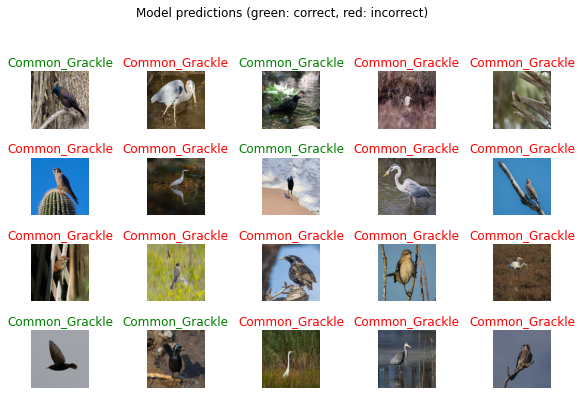

In [25]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
  _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")